In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

sample = pd.read_csv("SampleSubmission.csv")

In [2]:
import tensorflow as tf

ModuleNotFoundError: No module named 'tensorflow.python'

In [246]:
#Combine test and train into one file
train['source']='train'
test['source']='test'
data = pd.concat([train, test],ignore_index=True)
print (train.shape, test.shape, data.shape)

(4990, 14) (3532, 13) (8522, 14)


In [247]:
data.isnull().sum()

Product_Fat_Content                  0
Product_Identifier                   0
Product_Price                        0
Product_Shelf_Visibility             0
Product_Supermarket_Identifier       0
Product_Supermarket_Sales         3532
Product_Type                         0
Product_Weight                    1463
Supermarket _Size                 2409
Supermarket_Identifier               0
Supermarket_Location_Type            0
Supermarket_Opening_Year             0
Supermarket_Type                     0
source                               0
dtype: int64

In [248]:
product_avg_weight = data.pivot_table(values='Product_Weight', index='Product_Identifier')
def impute_weight(cols):
    Weight = cols[0]
    Identifier = cols[1]
    
    if pd.isnull(Weight):
        return product_avg_weight['Product_Weight'][product_avg_weight.index == Identifier]
    else:
        return Weight
    
    
print ('Orignal missing: %d'% sum(data['Product_Weight'].isnull()))
data['Product_Weight'] = data[['Product_Weight','Product_Identifier']].apply(impute_weight, axis=1).astype(float)
print ('Final missing: %d'% sum(data['Product_Weight'].isnull()))

Orignal missing: 1463
Final missing: 4


In [249]:
data['Product_Weight'] = data['Product_Weight'].fillna(12)
sum(data['Product_Weight'].isnull())

0

In [250]:
supermarket_size_mode = data.pivot_table(values='Supermarket _Size', columns = 'Supermarket_Type',aggfunc=lambda x: x.mode())
def impute_size_mode(cols):
    Size = cols[0]
    Type = cols[1]
    if pd.isnull(Size):
        return supermarket_size_mode.loc['Supermarket _Size'][supermarket_size_mode.columns == Type][0]
    else:
        return Size

print ('Orignal #missing: %d'%sum(data['Supermarket _Size'].isnull()))
data['Supermarket _Size'] = data[['Supermarket _Size','Supermarket_Type']].apply(impute_size_mode,axis=1)
print ('Final #missing: %d'%sum(data['Supermarket _Size'].isnull()))

Orignal #missing: 2409
Final #missing: 0


In [251]:
data['Supermarket_Opening_Year'] = 2016 - data['Supermarket_Opening_Year']
data['Supermarket_Opening_Year'].describe()

count    8522.000000
mean       11.168153
std         8.372251
min         0.000000
25%         5.000000
50%        10.000000
75%        22.000000
max        24.000000
Name: Supermarket_Opening_Year, dtype: float64

In [252]:
data.head()

,Product_Fat_Content,Product_Identifier,Product_Price,Product_Shelf_Visibility,Product_Supermarket_Identifier,Product_Supermarket_Sales,Product_Type,Product_Weight,Supermarket _Size,Supermarket_Identifier,Supermarket_Location_Type,Supermarket_Opening_Year,Supermarket_Type,source
0,Low Fat,DRA12,357.54,0.068535,DRA12_CHUKWUDI010,709.08,Soft Drinks,11.6,Small,CHUKWUDI010,Cluster 3,11,Grocery Store,train
1,Low Fat,DRA12,355.79,0.040912,DRA12_CHUKWUDI013,6381.69,Soft Drinks,11.6,High,CHUKWUDI013,Cluster 3,22,Supermarket Type1,train
2,Low Fat,DRA12,350.79,0.041178,DRA12_CHUKWUDI017,6381.69,Soft Drinks,11.6,Small,CHUKWUDI017,Cluster 2,2,Supermarket Type1,train
3,Low Fat,DRA12,355.04,0.041113,DRA12_CHUKWUDI018,2127.23,Soft Drinks,11.6,Medium,CHUKWUDI018,Cluster 3,0,Supermarket Type2,train
4,Ultra Low fat,DRA12,354.79,0.000000,DRA12_CHUKWUDI035,2481.77,Soft Drinks,11.6,Small,CHUKWUDI035,Cluster 2,5,Supermarket Type1,train


In [253]:
cols = ['Product_Price','Product_Shelf_Visibility','Product_Weight']
data[cols] = data[cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [254]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8522 entries, 0 to 8521
Data columns (total 14 columns):
Product_Fat_Content               8522 non-null object
Product_Identifier                8522 non-null object
Product_Price                     8522 non-null float64
Product_Shelf_Visibility          8522 non-null float64
Product_Supermarket_Identifier    8522 non-null object
Product_Supermarket_Sales         4990 non-null float64
Product_Type                      8522 non-null object
Product_Weight                    8522 non-null float64
Supermarket _Size                 8522 non-null object
Supermarket_Identifier            8522 non-null object
Supermarket_Location_Type         8522 non-null object
Supermarket_Opening_Year          8522 non-null int64
Supermarket_Type                  8522 non-null object
source                            8522 non-null object
dtypes: float64(4), int64(1), object(9)
memory usage: 932.2+ KB


In [255]:
price = tf.feature_column.numeric_column('Product_Price')
visibility = tf.feature_column.numeric_column('Product_Shelf_Visibility')
weight = tf.feature_column.numeric_column('Product_Weight')
age = tf.feature_column.numeric_column('Supermarket_Opening_Year')

In [256]:
assigned_group_FC = tf.feature_column.categorical_column_with_hash_bucket('Product_Fat_Content', hash_bucket_size=10)
assigned_group_PT = tf.feature_column.categorical_column_with_hash_bucket('Product_Type', hash_bucket_size=10)
#assigned_group_SS = tf.feature_column.categorical_column_with_hash_bucket('Supermarket _Size', hash_bucket_size=10)
assigned_group_SI = tf.feature_column.categorical_column_with_hash_bucket('Supermarket_Identifier', hash_bucket_size=10)
assigned_group_LT = tf.feature_column.categorical_column_with_hash_bucket('Supermarket_Location_Type', hash_bucket_size=10)
assigned_group_ST = tf.feature_column.categorical_column_with_hash_bucket('Supermarket_Type', hash_bucket_size=10)

In [257]:
embedded_group_FC = tf.feature_column.embedding_column(assigned_group_FC, dimension=3)
embedded_group_PT = tf.feature_column.embedding_column(assigned_group_PT, dimension=16)
#embedded_group_SS = tf.feature_column.embedding_column(assigned_group_SS, dimension=3)
embedded_group_SI = tf.feature_column.embedding_column(assigned_group_SI, dimension=10)
embedded_group_LT = tf.feature_column.embedding_column(assigned_group_LT, dimension=3)
embedded_group_ST = tf.feature_column.embedding_column(assigned_group_ST, dimension=4)

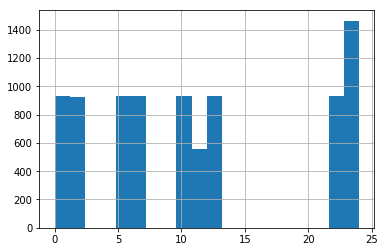

In [258]:
data['Supermarket_Opening_Year'].hist(bins=20)

In [259]:
age_buckets = tf.feature_column.bucketized_column(age, boundaries=[0,5,10,15,20,25,30])

In [260]:
feat_cols = [price, visibility, weight, embedded_group_FC, embedded_group_PT, #embedded_group_SS,
             embedded_group_SI, embedded_group_LT, embedded_group_ST, age_buckets]

In [261]:
#Drop the columns which have been converted to different types:
data.drop(['Product_Identifier','Product_Supermarket_Identifier'],axis=1,inplace=True)

In [262]:
#Divide into test and train:
train = data.loc[data['source']=="train"]
test = data.loc[data['source']=="test"]

In [263]:
train.head()

,Product_Fat_Content,Product_Price,Product_Shelf_Visibility,Product_Supermarket_Sales,Product_Type,Product_Weight,Supermarket _Size,Supermarket_Identifier,Supermarket_Location_Type,Supermarket_Opening_Year,Supermarket_Type,source
0,Low Fat,0.474219,0.208700,709.08,Soft Drinks,0.41947,Small,CHUKWUDI010,Cluster 3,11,Grocery Store,train
1,Low Fat,0.471247,0.124583,6381.69,Soft Drinks,0.41947,High,CHUKWUDI013,Cluster 3,22,Supermarket Type1,train
2,Low Fat,0.462758,0.125392,6381.69,Soft Drinks,0.41947,Small,CHUKWUDI017,Cluster 2,2,Supermarket Type1,train
3,Low Fat,0.469974,0.125194,2127.23,Soft Drinks,0.41947,Medium,CHUKWUDI018,Cluster 3,0,Supermarket Type2,train
4,Ultra Low fat,0.469550,0.000000,2481.77,Soft Drinks,0.41947,Small,CHUKWUDI035,Cluster 2,5,Supermarket Type1,train


In [264]:
#Drop unnecessary columns:
test.drop(['Product_Supermarket_Sales','source'],axis=1,inplace=True)
train.drop(['source'],axis=1,inplace=True)

C:\Users\mo.yosiwealth\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\mo.yosiwealth\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [273]:
y = train['Product_Supermarket_Sales']
X = train.drop(['Product_Supermarket_Sales'],axis=1)

In [274]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=101)

In [275]:
X_train.head()

,Product_Fat_Content,Product_Price,Product_Shelf_Visibility,Product_Type,Product_Weight,Supermarket _Size,Supermarket_Identifier,Supermarket_Location_Type,Supermarket_Opening_Year,Supermarket_Type
706,Normal Fat,0.774343,0.285969,Snack Foods,0.353974,Medium,CHUKWUDI049,Cluster 1,10,Supermarket Type1
4736,Low Fat,0.643763,0.161957,Health and Hygiene,0.493897,Medium,CHUKWUDI027,Cluster 3,24,Supermarket Type3
2859,Low Fat,0.473505,0.314735,Snack Foods,0.651682,High,CHUKWUDI013,Cluster 3,22,Supermarket Type1
705,Normal Fat,0.766278,0.286104,Snack Foods,0.353974,Small,CHUKWUDI045,Cluster 2,7,Supermarket Type1
189,Low Fat,0.513489,0.264262,Hard Drinks,0.257517,Small,CHUKWUDI046,Cluster 1,12,Supermarket Type1


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train[cols])

a = scaler.transform(X_train[cols])
b = scaler.transform(X_test[cols])

X_train = pd.DataFrame(data=a,columns = X_train[cols].columns,index=X_train.index)
X_test = pd.DataFrame(data=b,columns = X_test[cols].columns,index=X_test.index)

In [276]:
input_func = tf.estimator.inputs.pandas_input_fn(x=X_train,y=y_train,batch_size=10,num_epochs=1000,shuffle=True)

In [277]:
model = tf.estimator.DNNRegressor(hidden_units=[12,12,12,12,12,12],feature_columns=feat_cols)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\MOB005~1.YOS\\AppData\\Local\\Temp\\tmpcb2de3_s', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002398FB57DA0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [281]:
import time
t1 = time.time()

In [290]:
model.train(input_fn=input_func,steps=1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MOB005~1.YOS\AppData\Local\Temp\tmpcb2de3_s\model.ckpt-50000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 50001 into C:\Users\MOB005~1.YOS\AppData\Local\Temp\tmpcb2de3_s\model.ckpt.
INFO:tensorflow:loss = 98841860.0, step = 50001
INFO:tensorflow:global_step/sec: 57.7767
INFO:tensorflow:loss = 81288800.0, step = 50101 (1.746 sec)
INFO:tensorflow:global_step/sec: 114.281
INFO:tensorflow:loss = 17662244.0, step = 50201 (0.875 sec)
INFO:tensorflow:global_step/sec: 110.424
INFO:tensorflow:loss = 32953316.0, step = 50301 (0.901 sec)
INFO:tensorflow:global_step/sec: 115.314
INFO:tensorflow:loss = 125153900.0, step = 50401 (0.876 sec)
INFO:tensorflow:global_step/sec: 116.966
INFO:tensorflow:loss = 96654720.0, step = 

In [291]:
t2 = time.time()

print(t1)
print(t2)

1537822266.1659658
1537822841.046911


In [292]:
predict_input_func = tf.estimator.inputs.pandas_input_fn(
      x=X_test,
      batch_size=10,
      num_epochs=1,
      shuffle=False)

pred_gen = model.predict(predict_input_func)

predictions = list(pred_gen)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MOB005~1.YOS\AppData\Local\Temp\tmpcb2de3_s\model.ckpt-51000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [293]:
final_preds = []
for pred in predictions:
    final_preds.append(pred['predictions'])

from sklearn.metrics import mean_squared_error

mean_squared_error(y_test,final_preds)**0.5

2960.8772283785297

In [294]:
predict_new_data_func = tf.estimator.inputs.pandas_input_fn(
      x=test,
      batch_size=10,
      num_epochs=1,
      shuffle=False)

pred = model.predict(predict_new_data_func)

new_data_predictions = list(pred)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MOB005~1.YOS\AppData\Local\Temp\tmpcb2de3_s\model.ckpt-51000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [302]:
new_preds = []
for pred in new_data_predictions:
    new_preds.append(pred['predictions'])

In [297]:
#new_preds = pd.DataFrame(new_preds, columns=['pred'])

In [304]:
new_preds

[array([1496.0497], dtype=float32),
 array([8461.873], dtype=float32),
 array([8387.551], dtype=float32),
 array([1535.6998], dtype=float32),
 array([8235.633], dtype=float32),
 array([4621.8745], dtype=float32),
 array([8298.479], dtype=float32),
 array([4454.909], dtype=float32),
 array([2989.4824], dtype=float32),
 array([5982.6553], dtype=float32),
 array([2724.1646], dtype=float32),
 array([2844.2134], dtype=float32),
 array([2517.3416], dtype=float32),
 array([3110.6406], dtype=float32),
 array([2077.6018], dtype=float32),
 array([6364.534], dtype=float32),
 array([2574.8857], dtype=float32),
 array([2874.3052], dtype=float32),
 array([5734.4834], dtype=float32),
 array([4776.7812], dtype=float32),
 array([2639.8708], dtype=float32),
 array([792.9881], dtype=float32),
 array([7540.376], dtype=float32),
 array([3095.356], dtype=float32),
 array([3648.02], dtype=float32),
 array([2691.6597], dtype=float32),
 array([8705.135], dtype=float32),
 array([10313.949], dtype=float32),
 arr

In [305]:
submission = pd.DataFrame({'Product_Supermarket_Identifier':sample['Product_Supermarket_Identifier'],
                                  'Product_Supermarket_Sales': new_preds},
                                 columns=['Product_Supermarket_Identifier','Product_Supermarket_Sales'])

#to csv
submission.to_csv('aaaaaaaaaaaaaaaaaa.csv',index=False)